# Modules imports

In [ ]:
!pip install boto3 python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 8.4 MB/s eta 0:00:00


In [ ]:
boto3.__version__

'1.37.17'

In [ ]:
# Interact with AWS
import boto3

import os

# IAM roles
import json

# Load AWS credentials
from dotenv import load_dotenv

In [ ]:
# mount Drive in which we previously saved aws_credentials.env
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# AWS credentials

In [ ]:
# Copy AWS credentials from Drive to Colab
!cp "/content/drive/MyDrive/aws_credentials (1).env" .env

In [ ]:
# Load credentials from file .env
load_dotenv(".env", override=True)

True

In [ ]:
# Legge le credenziali AWS e la regione dal .env
AWS_IAM_USER = os.getenv("AWS_IAM_USER")
AWS_REGION = os.getenv("AWS_REGION", "eu-west-1")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
REDSHIFT_USER = os.getenv("REDSHIFT_USER")
REDSHIFT_PASSWORD = os.getenv("REDSHIFT_PASSWORD")

# Boto3 config

In [ ]:
# Configure boto3

s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("AWS_REGION")
)

# S3 buckets creation

In [ ]:
# added Account ID to the names of the buckets to avoid non unique global names
buckets = ["raw741448943196", "argento741448943196"]

# RAW will contain original csv uploaded
# SILVER will contain cleansed data

for bucket in buckets:
    try:
        s3.create_bucket(
            Bucket=bucket,
            CreateBucketConfiguration={'LocationConstraint': os.getenv("AWS_REGION")}
        )
        print(f"✅ Bucket '{bucket}' created!")
    except Exception as e:
        print(f"⚠️ Error in creation '{bucket}': {e}")

⚠️ Error in creation 'raw741448943196': An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.
⚠️ Error in creation 'argento741448943196': An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [ ]:
# GOLD will contain transformed data with moving average and join with Google Trends

gold_bucket = "gold741448943196"

try:
    s3.create_bucket(
        Bucket=gold_bucket,
        CreateBucketConfiguration={'LocationConstraint': os.getenv("AWS_REGION")}
    )
    print(f"✅ Bucket '{gold_bucket}' created!")
except Exception as e:
    print(f"⚠️ Errore in creation '{gold_bucket}': {e}")

⚠️ Errore in creation 'gold741448943196': An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


# Upload original data to raw bucket

In [ ]:
# Upload original files to raw bucket

raw_bucket = "raw741448943196"

files_to_upload = [
    "/content/drive/MyDrive/Data Engineering/ProfAI/AWS/BTC_EUR_Historical_Data.csv",
    "/content/drive/MyDrive/Data Engineering/ProfAI/AWS/XMR_EUR Kraken Historical Data.csv",
    "/content/drive/MyDrive/Data Engineering/ProfAI/AWS/google_trend_bitcoin.csv",
    "/content/drive/MyDrive/Data Engineering/ProfAI/AWS/google_trend_monero.csv"
]

In [ ]:
for file_path in files_to_upload:
    file_name = os.path.basename(file_path)
    s3.upload_file(file_path, raw_bucket, file_name)
    print(f"✅ {file_name} uploaded to S3 in bucket {raw_bucket}")

✅ BTC_EUR_Historical_Data.csv loaded to S3 in bucket raw741448943196
✅ XMR_EUR Kraken Historical Data.csv loaded to S3 in bucket raw741448943196
✅ google_trend_bitcoin.csv loaded to S3 in bucket raw741448943196
✅ google_trend_monero.csv loaded to S3 in bucket raw741448943196


# Glue

## IAM role for Glue

In [ ]:
iam = boto3.client(
    "iam",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("AWS_REGION"),
)

role_name = "AWSGlueCryptoRole"

# Allow Glue to access S3 and Data Catalog
trust_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {"Service": "glue.amazonaws.com"},
            "Action": "sts:AssumeRole"
        }
    ]
}

try:
    response = iam.create_role(
        RoleName=role_name,
        AssumeRolePolicyDocument=json.dumps(trust_policy),
        Description="Role for AWS Glue to access S3 and Glue Data Catalog"
    )
    role_arn = response["Role"]["Arn"]
    print(f"✅ Ruolo IAM '{role_name}' created! ARN: {role_arn}")
except Exception as e:
    print(f"⚠️ Role '{role_name}' already exists or there's an error: {e}")

# Assign policies
policies = [
    "arn:aws:iam::aws:policy/service-role/AWSGlueServiceRole",
    "arn:aws:iam::aws:policy/AmazonS3FullAccess"
]

for policy in policies:
    try:
        iam.attach_role_policy(RoleName=role_name, PolicyArn=policy)
        print(f"✅ Policy {policy} assignes to role {role_name}")
    except Exception as e:
        print(f"⚠️ Error in assigning policy {policy}: {e}")

✅ Ruolo IAM 'AWSGlueCryptoRole' created! ARN: arn:aws:iam::741448943196:role/AWSGlueCryptoRole
✅ Policy arn:aws:iam::aws:policy/service-role/AWSGlueServiceRole assignes to role AWSGlueCryptoRole
✅ Policy arn:aws:iam::aws:policy/AmazonS3FullAccess assignes to role AWSGlueCryptoRole


## Bucket policy

In [ ]:
s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="eu-west-1"
)

buckets = ["raw741448943196", "argento741448943196", "gold741448943196"]

for bucket in buckets:
    bucket_policy = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {"Service": "glue.amazonaws.com"},
                "Action": ["s3:GetObject", "s3:PutObject"],
                "Resource": [
                    f"arn:aws:s3:::{bucket}/*"
                ]
            },
            {
                "Effect": "Allow",
                "Principal": {"Service": "glue.amazonaws.com"},
                "Action": ["s3:ListBucket"],
                "Resource": f"arn:aws:s3:::{bucket}"
            }
        ]
    }

    try:
        s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(bucket_policy))
        print(f"✅ Policy assigned to bucket '{bucket}'")
    except Exception as e:
        print(f"⚠️ Errore in assigning policy to bucket '{bucket}': {e}")

✅ Policy assigned to bucket 'raw741448943196'
✅ Policy assigned to bucket 'argento741448943196'
✅ Policy assigned to bucket 'gold741448943196'


## 1) Raw to argento

In [ ]:
script_content = """
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# SparkSession
spark = SparkSession.builder.appName("RawToSilver").getOrCreate()

# 📂 S3 path
s3_input_path = "s3://raw741448943196/"
s3_output_path = "s3://argento741448943196/"

print(f"📂 Input Path: {s3_input_path}")
print(f"📂 Output Path: {s3_output_path}")

crypto_files = {
    "BTC": "BTC_EUR_Historical_Data.csv",
    "XMR": "XMR_EUR Kraken Historical Data.csv"
}

for crypto, filename in crypto_files.items():
    full_path = f"{s3_input_path}{filename}"
    print(f"🔹 Processing {crypto} from {full_path}...")

    try:
        # Read
        df = spark.read.option("header", "true").csv(full_path)
        print(f"✅ {crypto} - Reading succeded! Rows read: {df.count()}")

        # Select mandatory cols
        df = df.select("Date", "Price")

        # Remove rows where Price = -1
        df_cleaned = df.filter(col("Price") != "-1")
        print(f"✅ {crypto} - Cleaning completed! Rows after filtering: {df_cleaned.count()}")

        # Save to parquet
        output_path = f"{s3_output_path}{crypto}/"
        print(f"📂 Saving in {output_path}...")
        df_cleaned.write.mode("overwrite").parquet(output_path)

        print(f"✅ {crypto} - Writing completed!")

    except Exception as e:
        print(f"❌ Error during processing of {crypto}: {e}")

print("🚀 RawToSilver Job COMPLETED!")
"""

# **Save to S3**
script_path = "scripts/raw_to_silver.py"
bucket_name = "raw741448943196"

s3.put_object(Bucket=bucket_name, Key=script_path, Body=script_content)
print(f"✅ Script loaded to S3: s3://{bucket_name}/{script_path}")

# **Config Glue Job**
glue = boto3.client(
    "glue",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("AWS_REGION"),
)

# Job params
job_name = "RawToSilver"
script_location = f"s3://{bucket_name}/{script_path}"
role_arn = "arn:aws:iam::741448943196:role/AWSGlueCryptoRole"

# **Create or update job**
try:
    response = glue.create_job(
        Name=job_name,
        Role=role_arn,
        Command={"Name": "glueetl", "ScriptLocation": script_location, "PythonVersion": "3"},
        DefaultArguments={},  # 🔥 No TempDir!
        GlueVersion="3.0",
        WorkerType="Standard",
        NumberOfWorkers=1,
        MaxRetries=0
    )
    print(f"✅ Job AWS Glue '{job_name}' created!")

except glue.exceptions.AlreadyExistsException:
    print(f"⚠️ Job '{job_name}' already exists, updating...")

    response = glue.update_job(
        JobName=job_name,
        JobUpdate={
            "Role": role_arn,
            "Command": {"Name": "glueetl", "ScriptLocation": script_location, "PythonVersion": "3"},
            "DefaultArguments": {},
            "GlueVersion": "3.0",
            "WorkerType": "Standard",
            "NumberOfWorkers": 1,
            "MaxRetries": 0
        }
    )
    print(f"✅ Job AWS Glue '{job_name}' updated!")

except Exception as e:
    print(f"❌ Error in creation/updating Job '{job_name}': {str(e)}")

# **Job run**
response = glue.start_job_run(JobName="RawToSilver")
job_run_id = response["JobRunId"]
print(f"🚀 Job 'RawToSilver' run! JobRun ID: {job_run_id}")

✅ Script loaded to S3: s3://raw741448943196/scripts/raw_to_silver.py
✅ Job AWS Glue 'RawToSilver' created!
🚀 Job 'RawToSilver' run! JobRun ID: jr_b9b0fa6274e9510a3220b841fa445ff93dfe3cb7f3e727bc495207076730262e


## 2) Argento to gold

In [ ]:
script_content = """
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, avg, regexp_replace, round
from pyspark.sql.window import Window

# SparkSession
spark = SparkSession.builder.appName("ArgentoToGold").getOrCreate()

# 📂 S3 path
s3_input_path = "s3://argento741448943196/"
s3_trend_path = "s3://raw741448943196/"
s3_output_path = "s3://gold741448943196/"

print(f"📂 Input Path: {s3_input_path}")
print(f"📂 Output Path: {s3_output_path}")

crypto_files = {
    "BTC": {"price": "BTC/", "trend": "google_trend_bitcoin.csv"},
    "XMR": {"price": "XMR/", "trend": "google_trend_monero.csv"}
}

for crypto, paths in crypto_files.items():
    print(f"🔹 Processing {crypto} - Loading price data from {s3_input_path}{paths['price']}...")

    try:
        # Read Parquet price data
        df_silver = spark.read.option("header", "true").parquet(f"{s3_input_path}{paths['price']}")

        # Read CSV Google Trends data
        print(f"🔹 Processing {crypto} - Loading Google Trends from {s3_trend_path}{paths['trend']}...")
        df_gtrend = spark.read.option("header", "true").csv(f"{s3_trend_path}{paths['trend']}")


        interest_col = [col_name for col_name in df_gtrend.columns if "interesse" in col_name.lower()]
        df_gtrend = df_gtrend.withColumnRenamed(interest_col[0], "IndiceGoogleTrend")

        # Convert date cols to date type
        df_silver = df_silver.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy"))
        df_gtrend = df_gtrend.withColumn("Settimana", to_date(col("Settimana"), "yyyy-MM-dd"))

        # Rename "Settimana" in "Date" for join
        df_gtrend = df_gtrend.withColumnRenamed("Settimana", "Date")

        # Remove "," from numbers for cast
        df_silver = df_silver.withColumn("Price", regexp_replace(col("Price"), ",", ""))
        df_silver = df_silver.withColumn("Price", col("Price").cast("double"))

        # 10 days moving average
        window_spec = Window.orderBy("Date").rowsBetween(-9, 0)
        df_gold = df_silver.withColumn("Price", round(avg("Price").over(window_spec), 2))

        # Right Join
        df_gold = df_gold.join(df_gtrend, on="Date", how="right").select("Date", "Price", "IndiceGoogleTrend")


        print(f"📂 Saving unified data in {s3_output_path}{crypto}/...")
        df_gold.write.mode("overwrite").parquet(f"{s3_output_path}{crypto}/")

        print(f"✅ {crypto} - Writing completed!")

    except Exception as e:
        print(f"❌ Error during processing of {crypto}: {e}")

print("🚀 ArgentoToGold Job COMPLETED!")
"""

# **Save script to S3**
s3 = boto3.client("s3")
script_path = "scripts/argento_to_gold.py"
bucket_name = "raw741448943196"

s3.put_object(Bucket=bucket_name, Key=script_path, Body=script_content)
print(f"✅ Script uploaded on S3: s3://{bucket_name}/{script_path}")

# Initialize Glue Client
glue = boto3.client(
    "glue",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("AWS_REGION"),
)

# Job params
job_name = "ArgentoToGold"
script_location = f"s3://{bucket_name}/{script_path}"
role_arn = "arn:aws:iam::741448943196:role/AWSGlueCryptoRole"

# Create or update Glue job
try:
    response = glue.create_job(
        Name=job_name,
        Role=role_arn,
        Command={"Name": "glueetl", "ScriptLocation": script_location, "PythonVersion": "3"},
        DefaultArguments={},
        GlueVersion="3.0",
        WorkerType="Standard",
        NumberOfWorkers=1,
        MaxRetries=0
    )
    print(f"✅ Job AWS Glue '{job_name}' created!")

except glue.exceptions.AlreadyExistsException:
    print(f"⚠️ Job '{job_name}' already exists, uploading...")

    # If job already exists, update
    response = glue.update_job(
        JobName=job_name,
        JobUpdate={
            "Role": role_arn,
            "Command": {"Name": "glueetl", "ScriptLocation": script_location, "PythonVersion": "3"},
            "DefaultArguments": {},
            "GlueVersion": "3.0",
            "WorkerType": "Standard",
            "NumberOfWorkers": 1,
            "MaxRetries": 0
        }
    )
    print(f"✅ Job AWS Glue '{job_name}' updated!")

except Exception as e:
    print(f"❌ Error in creation/updating Job '{job_name}': {e}")

# **Job Glue run**
response = glue.start_job_run(JobName=job_name)
job_run_id = response["JobRunId"]
print(f"🚀 Job '{job_name}' run! JobRun ID: {job_run_id}")

✅ Script uploaded on S3: s3://raw741448943196/scripts/argento_to_gold.py
✅ Job AWS Glue 'ArgentoToGold' created!
🚀 Job 'ArgentoToGold' run! JobRun ID: jr_e00c9ee73da9dca508bebb79ea4da237a15e928c35bc7ce7163b03821c735b5f


Check in console: ✅ OK!

## 3) Gold to Redshift

In [ ]:
iam = boto3.client(
    "iam",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)

glue_role_name = "AWSGlueCryptoRole_GoldToRedshift"

trust_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {"Service": "glue.amazonaws.com"},
            "Action": "sts:AssumeRole"
        }
    ]
}

try:
    response = iam.create_role(
        RoleName=glue_role_name,
        AssumeRolePolicyDocument=json.dumps(trust_policy),
        Description="Glue role to load data from S3 to Redshift by user/password"
    )
    glue_role_arn = response["Role"]["Arn"]
    print(f"✅ Role IAM '{glue_role_name}' created! ARN: {glue_role_arn}")
except Exception as e:
    print(f"⚠️ Error in creation role (probably already existing): {e}")
    try:
        role_info = iam.get_role(RoleName=glue_role_name)
        glue_role_arn = role_info["Role"]["Arn"]
        print(f"ℹ️ Recovered existing ARN: {glue_role_arn}")
    except Exception as e:
        glue_role_arn = None
        print("❌ Impossible to recover role:", e)

# Attach policies to role
policies = [
    "arn:aws:iam::aws:policy/service-role/AWSGlueServiceRole",
    "arn:aws:iam::aws:policy/AmazonS3FullAccess",
    "arn:aws:iam::aws:policy/AmazonRedshiftAllCommandsFullAccess"
]
for policy_arn in policies:
    try:
        iam.attach_role_policy(RoleName=glue_role_name, PolicyArn=policy_arn)
        print(f"✅ Policy {policy_arn} attached to {glue_role_name}")
    except Exception as e:
        print(f"⚠️ Error in attaching policy {policy_arn}: {e}")

In [ ]:
policy_doc = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": glue_role_arn
        }
    ]
}

policy_name = "AllowPassRoleForGlueGoldToRedshift"

try:
    create_policy_resp = iam.create_policy(
        PolicyName=policy_name,
        PolicyDocument=json.dumps(policy_doc)
    )
    pass_role_policy_arn = create_policy_resp["Policy"]["Arn"]
    print("✅ policy PassRole created:", pass_role_policy_arn)
except iam.exceptions.EntityAlreadyExistsException:
    # Recover ARN if policy already exists
    policies_list = iam.list_policies(Scope='Local')
    pass_role_policy_arn = next(
        (p["Arn"] for p in policies_list["Policies"] if p["PolicyName"] == policy_name), None)
    print("ℹ️ Policy PassRole already existing:", pass_role_policy_arn)

user_name = os.getenv("AWS_IAM_USER")
if user_name:
    try:
        iam.attach_user_policy(UserName=user_name, PolicyArn=pass_role_policy_arn)
        print(f"✅ policy PassRole attached to user {user_name}")
    except Exception as e:
        print("⚠️ Error in attaching policy PassRole to user:", e)
else:
    print("ℹ️ Non specified IAM user (AWS_IAM_USER); ensure having iam:PassRole for our user.")

In [ ]:
##############################################
# Blocco 2: IAM role for Glue
##############################################
iam = boto3.client(
    "iam",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)

glue_role_name = "AWSGlueCryptoRole_GoldToRedshift"

# Allow Glue to assume this role
trust_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {"Service": "glue.amazonaws.com"},
            "Action": "sts:AssumeRole"
        }
    ]
}

try:
    response = iam.create_role(
        RoleName=glue_role_name,
        AssumeRolePolicyDocument=json.dumps(trust_policy),
        Description="Role for Glue to load data from S3 in Redshift by user/password"
    )
    glue_role_arn = response["Role"]["Arn"]
    print(f"✅ Role IAM '{glue_role_name}' created! ARN: {glue_role_arn}")
except Exception as e:
    print(f"⚠️ Error in creation of the role (probably already existing): {e}")
    try:
        role_info = iam.get_role(RoleName=glue_role_name)
        glue_role_arn = role_info["Role"]["Arn"]
        print(f"ℹ️ Recovered ARN existing: {glue_role_arn}")
    except Exception as e:
        glue_role_arn = None
        print("❌ Impossible recover the role:", e)

# Attach mandatory policies to role (Glue service, access to S3 and Redshift)
policies = [
    "arn:aws:iam::aws:policy/service-role/AWSGlueServiceRole",
    "arn:aws:iam::aws:policy/AmazonS3FullAccess",
    "arn:aws:iam::aws:policy/AmazonRedshiftAllCommandsFullAccess"
]
for policy_arn in policies:
    try:
        iam.attach_role_policy(RoleName=glue_role_name, PolicyArn=policy_arn)
        print(f"✅ Policy {policy_arn} attached to {glue_role_name}")
    except Exception as e:
        print(f"⚠️ Error in assigning policy {policy_arn}: {e}")

###############################################
# Blocco 3: Add policy iam:PassRole
###############################################
# This policy allow iam user (Colab) to pass role to Glue.
policy_doc = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": glue_role_arn
        }
    ]
}
policy_name = "AllowPassRoleForGlueGoldToRedshift"
try:
    create_policy_resp = iam.create_policy(
        PolicyName=policy_name,
        PolicyDocument=json.dumps(policy_doc)
    )
    pass_role_policy_arn = create_policy_resp["Policy"]["Arn"]
    print("✅ policy PassRole created:", pass_role_policy_arn)
except iam.exceptions.EntityAlreadyExistsException:
    policies_list = iam.list_policies(Scope='Local')
    pass_role_policy_arn = next(
        (p["Arn"] for p in policies_list["Policies"] if p["PolicyName"] == policy_name), None)
    print("ℹ️ Policy PassRole already existing:", pass_role_policy_arn)

# Attach policy to our IAM user (.env)
if AWS_IAM_USER:
    try:
        iam.attach_user_policy(UserName=AWS_IAM_USER, PolicyArn=pass_role_policy_arn)
        print(f"✅ policy PassRole attached to user {AWS_IAM_USER}")
    except Exception as e:
        print("⚠️ Error in attaching policy PassRole to user:", e)
else:
    print("ℹ️ AWS_IAM_USER non specified in .env")

###############################################################
# Blocco 4: PySpark Script to load data "gold" in Redshift
###############################################################
# Params redshift_user and redshift_pass will be passed to job Glue.

script_content = r"""
import sys
from awsglue.utils import getResolvedOptions
from pyspark.sql import SparkSession

# Recover params --redshift_user e --redshift_pass passed to the job
args = getResolvedOptions(sys.argv, ['redshift_user','redshift_pass'])
redshift_user = args['redshift_user']
redshift_password = args['redshift_pass']

spark = SparkSession.builder.appName("GoldToRedshift").getOrCreate()

btc_path = "s3://gold741448943196/BTC/"
xmr_path = "s3://gold741448943196/XMR/"

df_btc = spark.read.parquet(btc_path)
df_xmr = spark.read.parquet(xmr_path)

# endpoint Redshift
redshift_url = "jdbc:redshift://default-workgroup.741448943196.eu-west-1.redshift-serverless.amazonaws.com:5439/dev"

btc_table = "public.crypto_btc"
xmr_table = "public.crypto_xmr"

# Write table BTC in Redshift
df_btc.write \
  .format("jdbc") \
  .option("url", redshift_url) \
  .option("dbtable", btc_table) \
  .option("user", redshift_user) \
  .option("password", redshift_password) \
  .mode("overwrite") \
  .save()

print(f"✅ BTC data loaded to table {btc_table}")

# Write table XMR in Redshift
df_xmr.write \
  .format("jdbc") \
  .option("url", redshift_url) \
  .option("dbtable", xmr_table) \
  .option("user", redshift_user) \
  .option("password", redshift_password) \
  .mode("overwrite") \
  .save()

print(f"✅ XMR data loaded in table {xmr_table}")
print("🚀 Loading completed!")
"""

###############################################################
# Blocco 5: Load script PySpark to S3
###############################################################
s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)

script_bucket = "raw741448943196"
script_key = "scripts/gold_to_redshift.py"

try:
    s3.put_object(Bucket=script_bucket, Key=script_key, Body=script_content)
    print(f"✅ Script loaded to S3: s3://{script_bucket}/{script_key}")
except Exception as e:
    print(f"⚠️ Error in loading script to S3: {e}")

###############################################################
# Blocco 6: Job Glue "GoldToRedshift" creation/updating
###############################################################
glue = boto3.client(
    "glue",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)

job_name = "GoldToRedshift"
script_location = f"s3://{script_bucket}/{script_key}"

try:
    resp = glue.create_job(
    Name=job_name,
    Role=glue_role_arn,
    Command={
        "Name": "glueetl",
        "ScriptLocation": script_location,
        "PythonVersion": "3"
    },
    DefaultArguments={},
    GlueVersion="3.0",
    WorkerType="Standard",
    NumberOfWorkers=1,
    MaxRetries=0
)
    print(f"✅ Job Glue '{job_name}' created!")
except glue.exceptions.AlreadyExistsException:
    print(f"⚠️ Job '{job_name}' already existing, updating...")
    resp = glue.update_job(
        JobName=job_name,
        JobUpdate={
            "Role": glue_role_arn,
            "Command": {
                "Name": "glueetl",
                "ScriptLocation": script_location,
                "PythonVersion": "3"
            },
            "DefaultArguments": {},
            "GlueVersion": "3.0",
            "WorkerType": "Standard",
            "NumberOfWorkers": 1,
            "MaxRetries": 0
        }
    )
    print(f"✅ Job Glue '{job_name}' updated!")
except Exception as e:
    print(f"❌ Error in creation/updating job '{job_name}': {e}")

###############################################################
# Blocco 7: Job Glue run passing user and password for Redshift
###############################################################
try:
    run_resp = glue.start_job_run(
        JobName=job_name,
        Arguments={
            "--redshift_user": os.getenv("REDSHIFT_USER"),
            "--redshift_pass": os.getenv("REDSHIFT_PASSWORD")
        }
    )
    job_run_id = run_resp["JobRunId"]
    print(f"🚀 Job '{job_name}' run! JobRun ID: {job_run_id}")
except Exception as e:
    print(f"❌ Error in running of the job '{job_name}': {e}")

print("END: 'gold' data loaded to Redshift (tables: public.crypto_btc and public.crypto_xmr) in default db!")

Check in console: ✅ OK!

# Step function

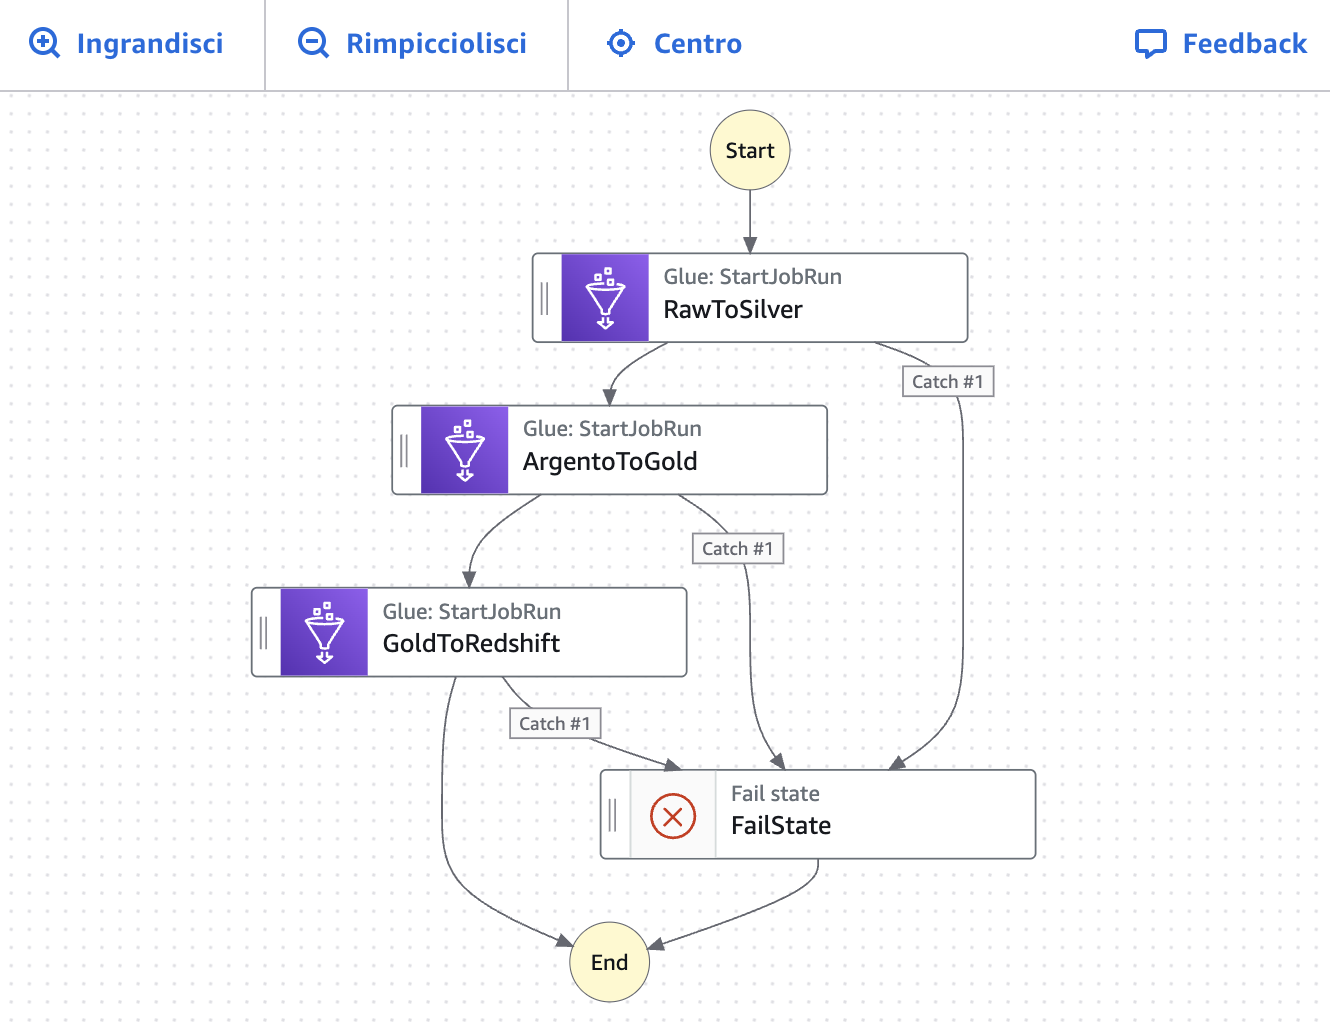